First step：prepare data.
1. Join choices dataset with user survey dataset, extract userid whose userid is in both datasets.
2. Limit each user's data records to maxium 26

In [ ]:
import pandas as pd
import numpy as np
# load main dataset with certain columns
main = 'SharedResponses.csv'
all_columns = pd.read_csv(main, nrows=0).columns.tolist()
selected_columns = all_columns[:8] + all_columns[14:17] + all_columns[-20:]

# create a new dataframe
df_main = pd.DataFrame()

# load data
for chunk in pd.read_csv(main, usecols=selected_columns, chunksize=1000000, low_memory=False):
    df_main = pd.concat([df_main, chunk], ignore_index=True)
print(df_main.head())

# df_main.to_csv('main_feature_1.csv')

In [3]:
file_path = 'SharedResponsesSurvey.csv'

# extract 'UserID' that has only one unique gender from survey dataset

columns_to_load = ['UserID', 'Review_gender']
df = pd.read_csv(file_path, usecols=columns_to_load)
df = df[df['Review_gender'].isin(['male', 'female'])]

unique_counts = df.groupby('UserID')['Review_gender'].nunique()

user_ids_with_single_gender = unique_counts[unique_counts == 1].index

df_filtered = df[df['UserID'].isin(user_ids_with_single_gender)]

df_unique = df_filtered.drop_duplicates()

In [4]:
merged_chunks = []

chunksize = 100000
f1_path = 'main_feature_1.csv'
# merge 32 columns' main data with user data through 'UserID'
for chunk in pd.read_csv(f1_path, chunksize=chunksize):
    merged_chunk = pd.merge(df_unique, chunk, on='UserID', how='inner')
    merged_chunks.append(merged_chunk)

final_merged_df = pd.concat(merged_chunks, ignore_index=True)

print(final_merged_df.shape)

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_21308/99572498.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_21308/99572498.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_21308/99572498.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_21308/99572498.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000

(11437413, 33)


Strategy of filtering data:

Step 1: Group by UserID and calculate the total data volume and unique ResponseID number for each user. If total=26 and unique=13, keep all data of these users.
Step 2: If total<26, filter out all rows where ResponseID appears twice and the Saved column is 0 and 1 respectively, and keep this part of the data.
Step 3: If total>26, randomly select 13 ResponseIDs, and these ResponseIDs appear twice and the Saved column is 0 and 1 respectively.

In [ ]:
import pandas as pd
import numpy as np

# group by UserID and calculate total rows per user
grouped_df = final_merged_df.groupby('UserID').agg(
    total_rows=('UserID', 'size'),  
    unique_responseids=('ResponseID', 'nunique')  
).reset_index()

# Step 1: keep data that total = 26 & unique = 13 
condition_1 = grouped_df[(grouped_df['total_rows'] == 26) & (grouped_df['unique_responseids'] == 13)]
filtered_df_1 = final_merged_df[final_merged_df['UserID'].isin(condition_1['UserID'])]

# Step 2: for users whose total < 26，make sure responseid is paired
condition_2 = grouped_df[grouped_df['total_rows'] < 26]

# total < 26
filtered_df_2 = final_merged_df[final_merged_df['UserID'].isin(condition_2['UserID'])]

# filter ResponseID = 2 & Saved contains 0 and 1
def filter_responseid_group(group):
    valid_responses = group.groupby('ResponseID').filter(lambda x: (len(x) == 2) and (x['Saved'].nunique() == 2))
    return valid_responses

filtered_df_2 = filtered_df_2.groupby('UserID').apply(filter_responseid_group).reset_index(drop=True)

# Step 3: for users whose total > 26 的用户，pick 13 valid ResponseID randomaly
condition_3 = grouped_df[grouped_df['total_rows'] > 26]

# total > 26
filtered_df_3 = final_merged_df[final_merged_df['UserID'].isin(condition_3['UserID'])]

def random_sample(group):
    valid_responses = group.groupby('ResponseID').filter(lambda x: (len(x) == 2) and (x['Saved'].nunique() == 2))
    
    if len(valid_responses['ResponseID'].unique()) > 13:
        selected_responseids = np.random.choice(valid_responses['ResponseID'].unique(), size=13, replace=False)
        
        sample_responses = valid_responses[valid_responses['ResponseID'].isin(selected_responseids)]
        return sample_responses
    else:
        return valid_responses

filtered_df_3 = filtered_df_3.groupby('UserID').apply(random_sample).reset_index(drop=True)

# concat
final_filtered_df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3], ignore_index=True)

print(final_filtered_df)

plot distribution of gender

In [1]:
import pandas as pd

df = pd.read_csv('/Users/aklat/Downloads/Thsesis/Datasets/Moral Machine Data/1123_final_join_1.csv')

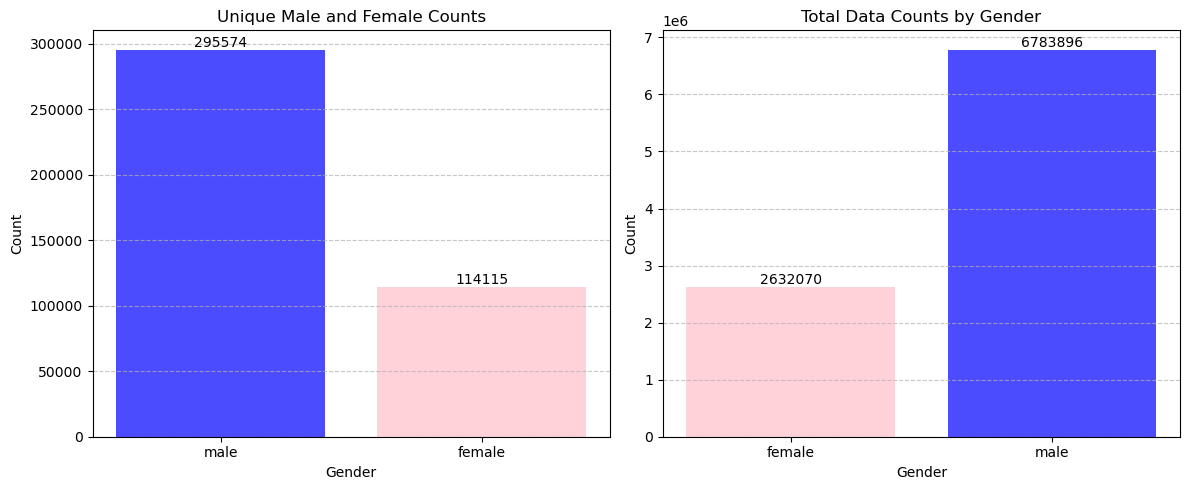

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

unique_counts = df.drop_duplicates(subset='UserID')['Review_gender'].value_counts()
total_counts = df.groupby('Review_gender').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars1 = axes[0].bar(unique_counts.index, unique_counts.values, color=['blue', 'pink'], alpha=0.7)
axes[0].set_title('Unique Male and Female Counts')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Gender')
axes[0].set_xticks(range(len(unique_counts.index)))
axes[0].set_xticklabels(unique_counts.index)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

bars2 = axes[1].bar(total_counts.index, total_counts.values, color=['pink', 'blue'], alpha=0.7)
axes[1].set_title('Total Data Counts by Gender')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Gender')
axes[1].set_xticks(range(len(total_counts.index)))
axes[1].set_xticklabels(total_counts.index)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()